BMI HW 3

Saumya Diwan

Problem: Model-based Bias Removal in Machine Learning using Synthetic Blood Pressure Data

In [101]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [38]:
#used generative AI to convert table in reference table from the preprint mentioned in the assignmetn
# --- Step 1: Define data ---
data = {
    "Age": ["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "≥90"],
    "Number": [193631, 547023, 674798, 806952, 984094, 1012979, 732165, 305157, 60637],
    "%": [3.6, 10.3, 12.7, 15.2, 18.5, 19.1, 13.8, 5.7, 1.1],
    "mean_SBP": [115.05, 121.27, 123.79, 127.32, 129.98, 132.42, 134.62, 136.89, 138.11],
    "std_SBP": [13.65, 14.19, 15.91, 16.93, 17.19, 17.13, 17.36, 18.35, 19.59],
    "mean_DBP": [69.80, 74.27, 77.31, 79.36, 79.05, 76.71, 74.06, 71.56, 69.86],
    "std_DBP": [8.90, 9.60, 10.48, 10.46, 9.88, 9.38, 9.11, 9.22, 9.44],
    "rho_SBP_DBP": [0.61, 0.66, 0.74, 0.73, 0.67, 0.58, 0.52, 0.49, 0.50]
}

# --- Step 2: Create DataFrame ---
df = pd.DataFrame(data)

# --- Step 3: Compute class marks (midpoint of age ranges) ---
def get_class_mark(age_str):
    if "<" in age_str:
        return 10
    elif "≥" in age_str or ">" in age_str:
        return 95
    else:
        start, end = map(int, age_str.split('-'))
        return (start + end) / 2

df["Age_class_mark"] = df["Age"].apply(get_class_mark)

# --- Step 4: Display the DataFrame ---
print(df)


     Age   Number     %  mean_SBP  std_SBP  mean_DBP  std_DBP  rho_SBP_DBP  \
0    <20   193631   3.6    115.05    13.65     69.80     8.90         0.61   
1  20-29   547023  10.3    121.27    14.19     74.27     9.60         0.66   
2  30-39   674798  12.7    123.79    15.91     77.31    10.48         0.74   
3  40-49   806952  15.2    127.32    16.93     79.36    10.46         0.73   
4  50-59   984094  18.5    129.98    17.19     79.05     9.88         0.67   
5  60-69  1012979  19.1    132.42    17.13     76.71     9.38         0.58   
6  70-79   732165  13.8    134.62    17.36     74.06     9.11         0.52   
7  80-89   305157   5.7    136.89    18.35     71.56     9.22         0.49   
8    ≥90    60637   1.1    138.11    19.59     69.86     9.44         0.50   

   Age_class_mark  
0            10.0  
1            24.5  
2            34.5  
3            44.5  
4            54.5  
5            64.5  
6            74.5  
7            84.5  
8            95.0  


In [39]:
#Polynomial functions from the assignment (a is age in years and ci and di are coefficients)
#SBP(a) = c1a2 + c2a + c3
#DBP(a) = d1a2 + d2a + d3

#A i
def polynomial_sbp_a(a,c1,c2,c3):
  function_sbp= c1*a**2 + c2*a + c3
  return function_sbp

def polynomial_dbp_a(a,d1,d2,d3):
  function_dbp= d1*a**2 + d2*a + d3
  return function_dbp

def sigmoid_sbp_a(a,Smax,k,a0):
  function_sbp_sigmoid= Smax/(1+np.exp(-k*(a-a0)))
  return function_sbp_sigmoid

def gaussian_dbp_a(a,Dmax,apeak,sigma):
  function_dbp_gaussian= Dmax*np.exp(-(a-apeak)**2/(2*sigma**2))
  return function_dbp_gaussian


In [40]:
#model fitting
#A ii
#initial parameter seed points have been generated with generative AI fed with tabular data df
age_array = df["Age_class_mark"].values
sbp_array = df["mean_SBP"].values
dbp_array = df["mean_DBP"].values

coefficients_sbp, covariance_sbp = curve_fit(polynomial_sbp_a,age_array, sbp_array, p0=[-0.002, 0.3, 110])

coefficients_dbp, covariance_dbp = curve_fit(polynomial_dbp_a,age_array, dbp_array, p0=[-0.005, 0.9, 65])

coefficients_sbp_sigmoid, covariance_sbp_sigmoid = curve_fit(sigmoid_sbp_a,age_array, sbp_array,p0=[140, 0.07, 40])

coefficients_dbp_gaussian, covariance_dbp_gaussian = curve_fit(gaussian_dbp_a,age_array, dbp_array,p0=[80, 45, 20])

c1, c2, c3 = coefficients_sbp
d1, d2, d3 = coefficients_dbp
Smax,k,a0 = coefficients_sbp_sigmoid
Dmax,apeak,sigma = coefficients_dbp_gaussian

In [41]:
coefficients_table ={"Coefficients for SBP and DBP" : ["c1","c2","c3","d1", "d2", "d3","Smax","k","a0","Dmax","apeak","sigma"],
                     "Values": [c1,c2,c3,d1,d2,d3,Smax,k,a0,Dmax,apeak,sigma]}

coefficients_df = pd.DataFrame(coefficients_table)
print(coefficients_df)

   Coefficients for SBP and DBP      Values
0                            c1   -0.001532
1                            c2    0.431291
2                            c3  111.083788
3                            d1   -0.004983
4                            d2    0.505025
5                            d3   65.479662
6                          Smax  148.910538
7                             k    0.015761
8                            a0  -67.937007
9                          Dmax   78.372481
10                        apeak   50.569448
11                        sigma   85.573570


In [42]:
#for computing MSE and R^2, we need actual vs predicted points to evaluate the model fitting
#generating predictions
age_points= np.linspace(10,95,500)
predictions_sbp_polynomial = polynomial_sbp_a(age_points,c1,c2,c3)
predictions_dbp_polynomial = polynomial_dbp_a(age_points,d1,d2,d3)
predictions_sbp_sigmoid = sigmoid_sbp_a(age_points,Smax,k,a0)
predictions_dbp_gaussian = gaussian_dbp_a(age_points,Dmax,apeak,sigma)


In [43]:
# A iii
#computing MSE and R^2 for these predictions vs actual
mse_sbp_polynomial = mean_squared_error(sbp_array, polynomial_sbp_a(age_array,c1,c2,c3))
mse_dbp_polynomial = mean_squared_error(dbp_array, polynomial_dbp_a(age_array,d1,d2,d3))
mse_sbp_sigmoid = mean_squared_error(sbp_array, sigmoid_sbp_a(age_array,Smax,k,a0))
mse_dbp_gaussian = mean_squared_error(dbp_array, gaussian_dbp_a(age_array,Dmax,apeak,sigma))

r2_sbp_polynomial = r2_score(sbp_array,  polynomial_sbp_a(age_array,c1,c2,c3))
r2_dbp_polynomial = r2_score(dbp_array, polynomial_dbp_a(age_array,d1,d2,d3))
r2_sbp_sigmoid = r2_score(sbp_array, sigmoid_sbp_a(age_array,Smax,k,a0))
r2_dbp_gaussian = r2_score(dbp_array, gaussian_dbp_a(age_array,Dmax,apeak,sigma))

Results_table = {"Model": ["Polynomial SBP", "Polynomial DBP", "Sigmoid SBP", "Gaussian DBP"],
                 "MSE": [mse_sbp_polynomial, mse_dbp_polynomial, mse_sbp_sigmoid, mse_dbp_gaussian],
                 "R^2": [r2_sbp_polynomial, r2_dbp_polynomial, r2_sbp_sigmoid, r2_dbp_gaussian]}
Results_table_df = pd.DataFrame(Results_table)
print(Results_table_df)

            Model       MSE       R^2
0  Polynomial SBP  0.065030  0.998764
1  Polynomial DBP  0.897586  0.926137
2     Sigmoid SBP  0.065419  0.998757
3    Gaussian DBP  0.800747  0.934106


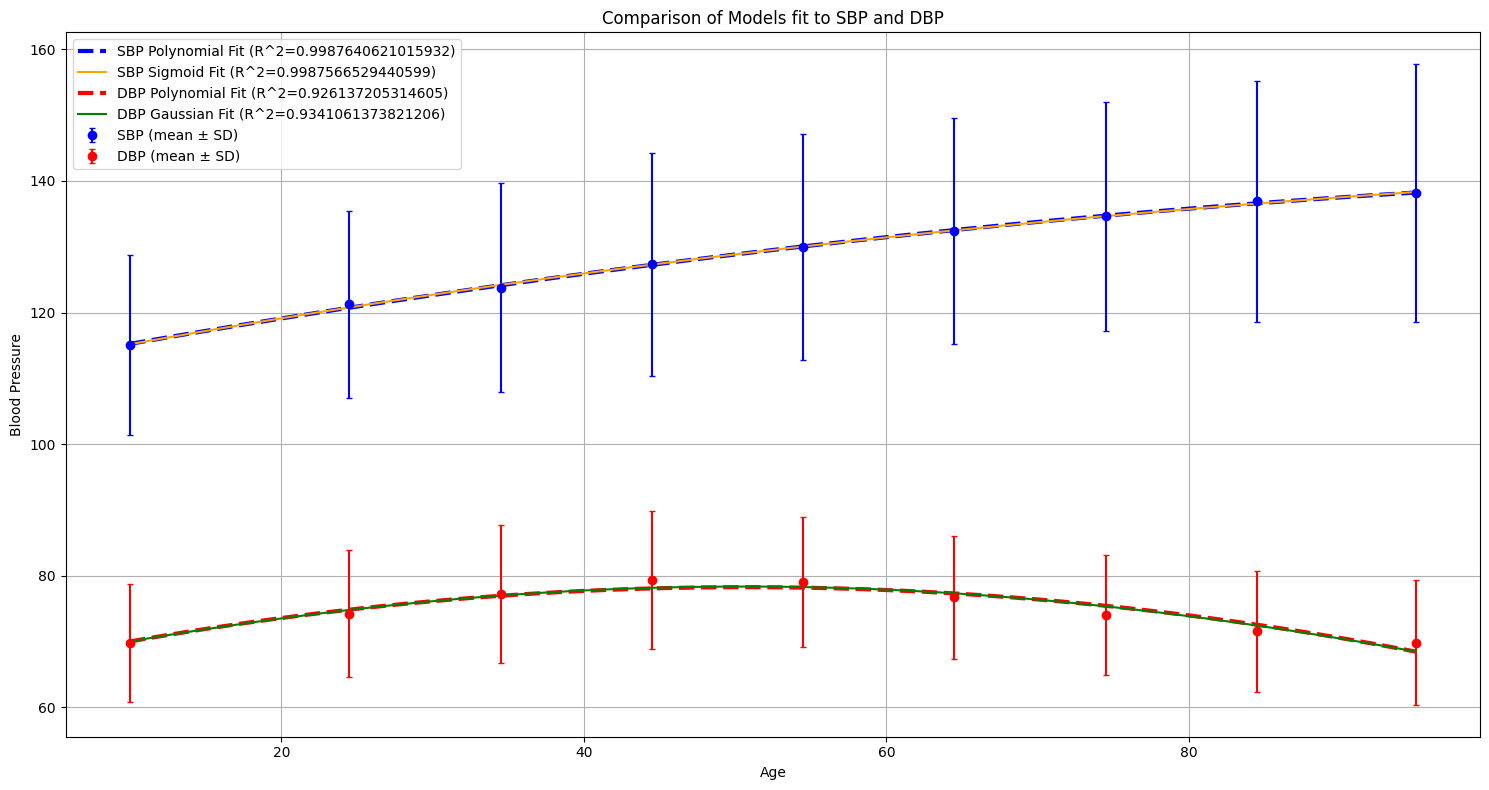

In [74]:
plt.figure(figsize=(15, 8))
#plt.scatter(age_array,sbp_array, label="SBP", color="blue")
#plt.scatter(age_array,dbp_array, label="DBP", color="red")
plt.errorbar(age_array,sbp_array, yerr=df["std_SBP"], label="SBP (mean ± SD)",color="blue",fmt='o',capsize=2)
plt.errorbar(age_array,dbp_array, yerr=df["std_DBP"], label="DBP (mean ± SD)",color="red",fmt='o',capsize=2)
plt.plot(age_points,predictions_sbp_polynomial, label=f"SBP Polynomial Fit (R^2={r2_sbp_polynomial})", color="blue",linestyle='dashed',linewidth=3)
plt.plot(age_points,predictions_sbp_sigmoid, label=f"SBP Sigmoid Fit (R^2={r2_sbp_sigmoid})", color="orange")
plt.plot(age_points,predictions_dbp_polynomial, label=f"DBP Polynomial Fit (R^2={r2_dbp_polynomial})", color="red",linestyle='dashed',linewidth=3)
plt.plot(age_points,predictions_dbp_gaussian, label=f"DBP Gaussian Fit (R^2={r2_dbp_gaussian})", color="green")
plt.title("Comparison of Models fit to SBP and DBP")
plt.xlabel("Age")
plt.ylabel("Blood Pressure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
# A iv


In [ ]:
# A v

In [ ]:
# B i

In [75]:
#AI generated function below
import numpy as np

# --- Given parameters ---
mean_A = 10.0
std_A  = 2.0
mean_B = 20.0
std_B  = 5.0
rho    = 0.6   # correlation between A and B

n_samples = 1000

# 1. Mean vector
mean = np.array([mean_A, mean_B])

# 2. Covariance matrix
cov_AB = rho * std_A * std_B
cov = np.array([
    [std_A**2,  cov_AB],
    [cov_AB,    std_B**2]
])

# 3. Generate samples from bivariate normal
rng = np.random.default_rng(seed=42)  # optional seed for reproducibility
samples = rng.multivariate_normal(mean, cov, size=n_samples)

# 4. Split back into A and B
A_synth = samples[:, 0]
B_synth = samples[:, 1]

print(A_synth.shape, B_synth.shape)  # (1000,) (1000,)


In [80]:
#adapting this here
sample_size = 100000
N_male=int(sample_size/2)
N_female=int(sample_size/2)


In [81]:
#creating arrays for mean mu and std for male and females separate
mu = [133.0, 78.8, 125.8,74.8]          # [mean SBP male, mean DBP male, mean SBP female,  mean DBP female]
std = [18.6, 12.6, 19.0, 12.4]          # [std SBP male, std DBP male, std SBP female,  std DBP female]
rho = [0.45, 0.5]                         # [correlation male, correaltion female]

#covariance matrices for male and fmale
covariance_matrix_male= [[std[0]**2, rho[0]*std[0]*std[1]],
                        [rho[0]*std[0]*std[1], std[1]**2]]
covariance_matrix_female= [[std[2]**2, rho[1]*std[2]*std[3]],
                        [rho[1]*std[2]*std[3], std[3]**2]]

# synthetic data geeneration using np.random.multivariate_normal
synthetic_male_dataset= np.random.multivariate_normal(mean=mu[:2], cov=covariance_matrix_male, size=N_male)
synthetic_female_dataset= np.random.multivariate_normal(mean=mu[2:], cov=covariance_matrix_female, size=N_female)


In [82]:
dataframe_male=pd.DataFrame(synthetic_male_dataset, columns=["SBP","DBP"])
dataframe_female=pd.DataFrame(synthetic_female_dataset, columns=["SBP","DBP"])
dataframe_male["Sex"]=1
dataframe_female["Sex"]=0

combined_synthetic_dataframe= pd.concat([dataframe_male, dataframe_female], ignore_index=True)
combined_synthetic_dataframe

,SBP,DBP,Sex
0,149.723697,84.637077,1
1,124.926061,89.283149,1
2,139.370434,61.062944,1
3,141.684999,80.702461,1
4,124.123713,77.999639,1
...,...,...,...
99995,134.292269,76.222072,0
99996,125.381188,68.269986,0
99997,130.448226,101.414755,0
99998,159.635038,90.654558,0


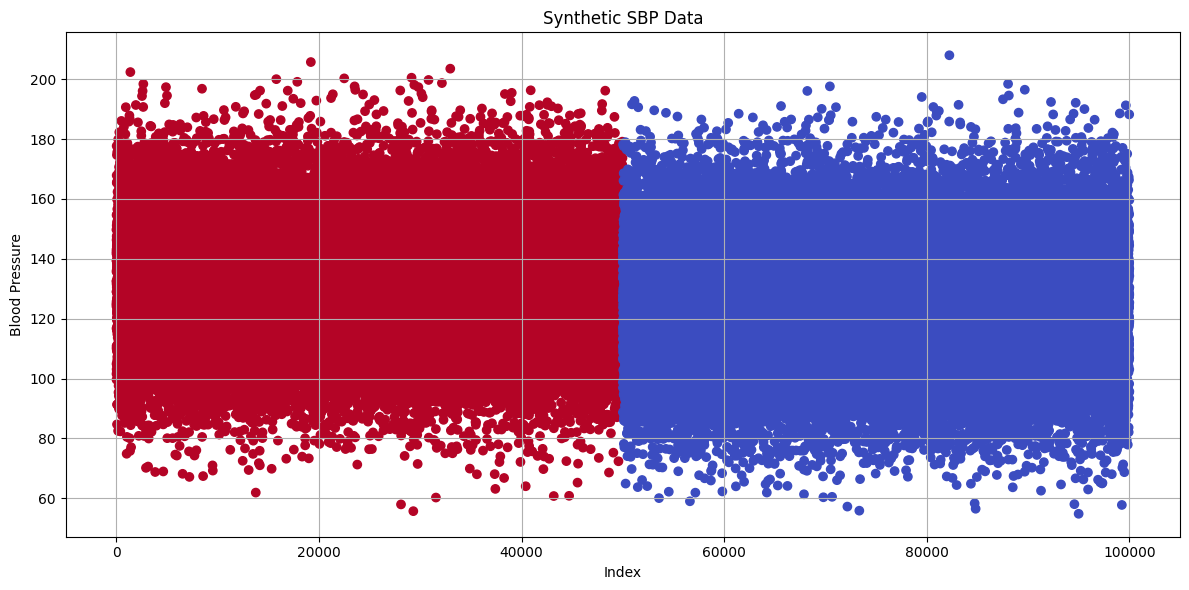

In [99]:
plt.figure(figsize=(12, 6))
plt.scatter(data=combined_synthetic_dataframe, x=combined_synthetic_dataframe.index, y="SBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic SBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.grid(True)
plt.tight_layout()
plt.show()


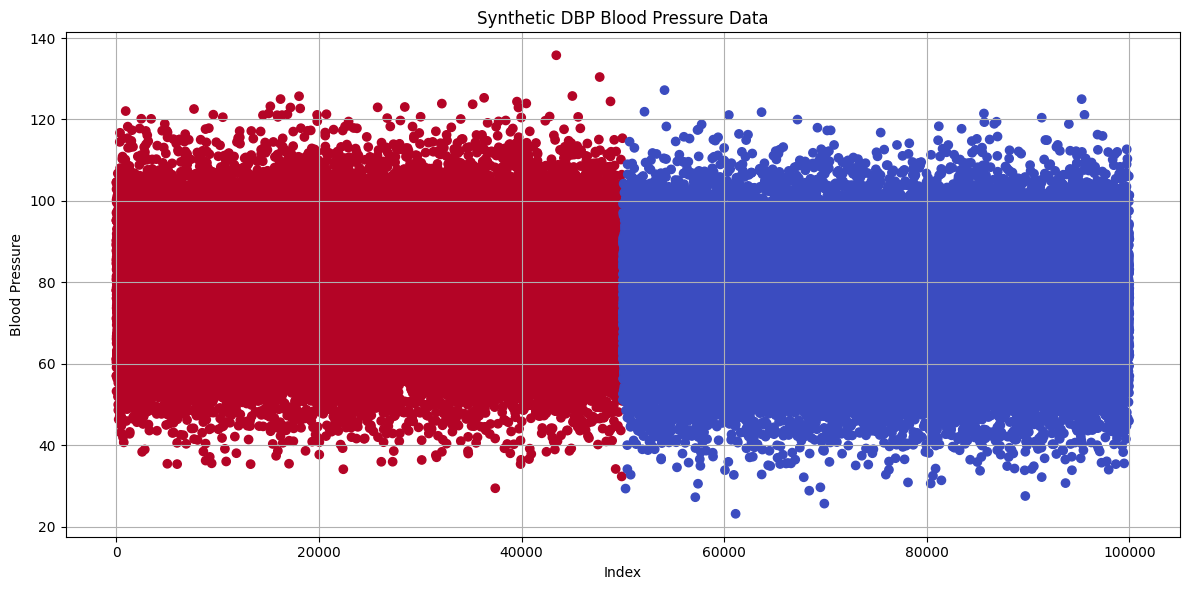

In [100]:
plt.figure(figsize=(12, 6))
plt.scatter(data=combined_synthetic_dataframe, x=combined_synthetic_dataframe.index, y="DBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic DBP Blood Pressure Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
#shuffling the dataframe indices to see the distribution better
shuffled_combined_synthetic_dataframe = combined_synthetic_dataframe.copy()
shuffled_combined_synthetic_dataframe = shuffled_combined_synthetic_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_combined_synthetic_dataframe

,SBP,DBP,Sex
0,121.638687,70.693270,0
1,116.448365,81.925401,0
2,158.849240,57.591914,1
3,98.937978,79.296376,0
4,137.302462,74.995713,0
...,...,...,...
99995,104.573011,71.502923,1
99996,151.484822,79.915980,0
99997,137.945856,80.888842,0
99998,135.173999,81.377515,1


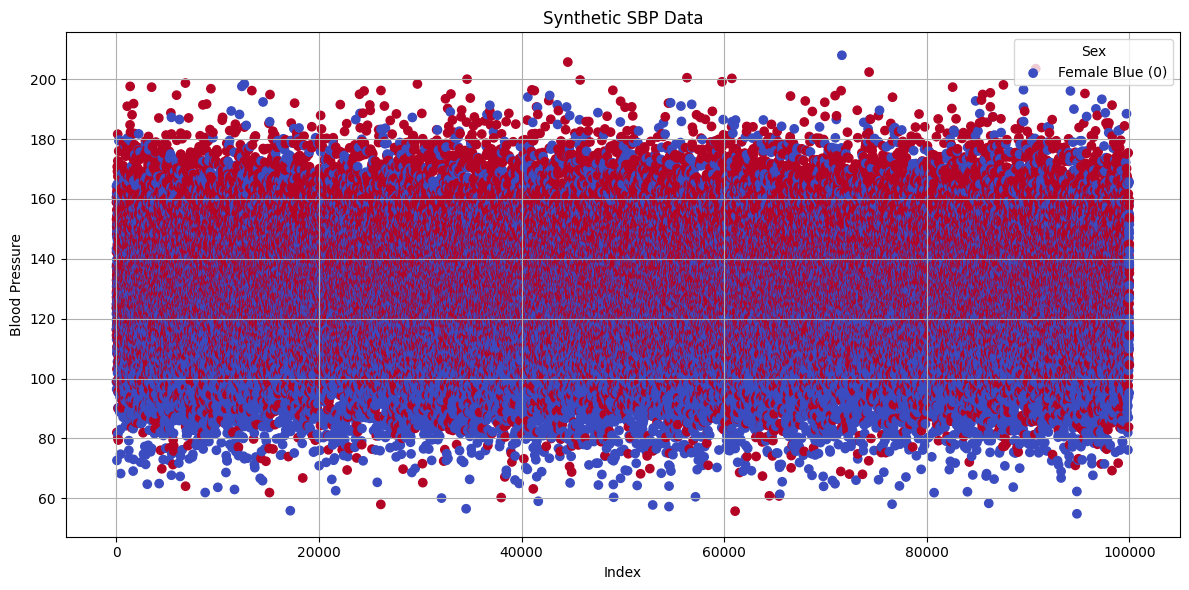

In [98]:
#plotting the synthetic data SBP
plt.figure(figsize=(12, 6))
plt.scatter(data=shuffled_combined_synthetic_dataframe, x=shuffled_combined_synthetic_dataframe.index, y="SBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic SBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.legend(title="Sex", labels=["Female Blue (0)"])
plt.grid(True)
plt.tight_layout()
plt.show()


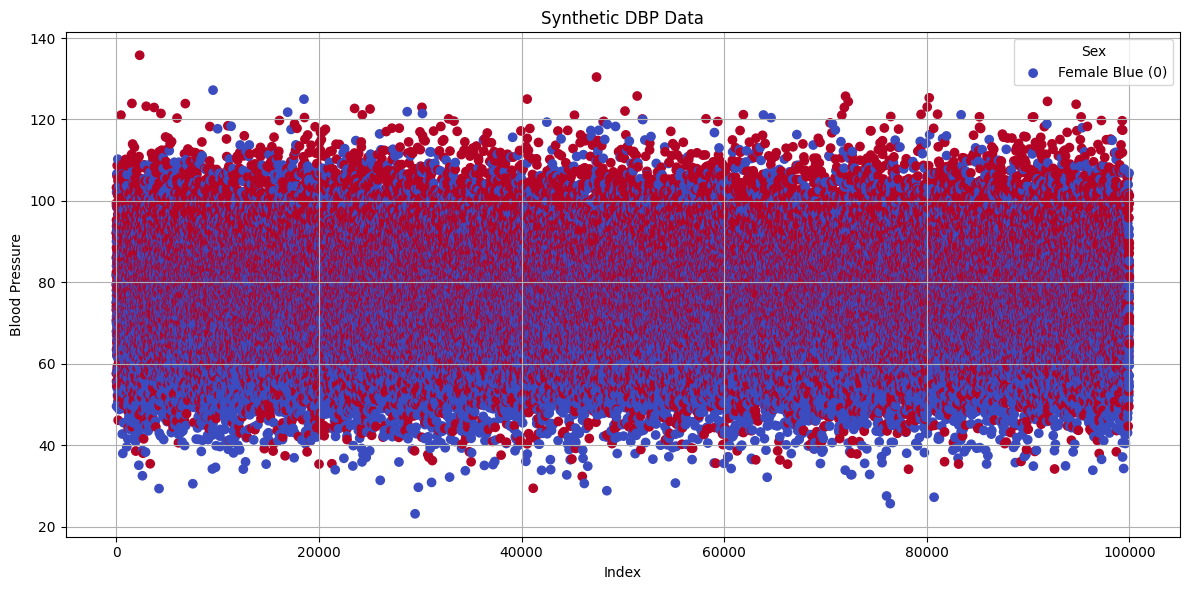

In [97]:
#plotting the synthetic data DBP

plt.figure(figsize=(12, 6))
plt.scatter(data=shuffled_combined_synthetic_dataframe, x=shuffled_combined_synthetic_dataframe.index, y="DBP", c="Sex", cmap="coolwarm")
plt.title("Synthetic DBP Data")
plt.xlabel("Index")
plt.ylabel("Blood Pressure")
plt.legend(title="Sex", labels=["Female Blue (0)"])
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# B ii
# X is the input data and y is the target
X = shuffled_combined_synthetic_dataframe[["SBP", "DBP"]]
y = shuffled_combined_synthetic_dataframe["Sex"]

#test train split without stratification of y sex
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#experimenting without stratification on y
model= logisticRegression()

#model fitting
model.fit(x_train, y_train)

#model predictions
y_pred= model.predict(x_test)

